# Data loading

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
#import tensorflow as tf
import seaborn as sns
#from pylab import rcParams
from sklearn.model_selection import train_test_split
#from keras.models import Model, load_model
#from keras.layers import Input, Dense
#from keras.callbacks import ModelCheckpoint, TensorBoard
#from keras import regularizers

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

import warnings
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Customer Profile.csv',parse_dates=['TransactionStartTime'])

In [3]:
data['month']=data['TransactionStartTime'].dt.month
data['quarter']=data['TransactionStartTime'].dt.quarter
#data['day']=data['TransactionStartTime'].dt.day
data['week_of_month']=data['TransactionStartTime'].dt.day//7
#data['day_of_year']=data['TransactionStartTime'].dt.dayofyear
data['weekday']=data['TransactionStartTime'].dt.weekday_name
data['hour']=data['TransactionStartTime'].dt.hour
#data['week']=data['TransactionStartTime'].dt.week
#data['minute']=data['TransactionStartTime'].dt.minute
#data['seconds']=data['TransactionStartTime'].dt.second
data.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
data.drop('Unnamed: 0',inplace=True,axis=1)

In [5]:
test=data[data.FraudResult.isnull()]
train=data.dropna()

In [6]:
a=train.drop(['FraudResult','CurrencyCode', 'CountryCode','TransactionId','BatchId',
              'AccountId','SubscriptionId','CustomerId','TransactionStartTime'],axis=1)
b=train['FraudResult']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(a.drop('month',axis=1), b, test_size=0.3, random_state=4092)

In [8]:
from sklearn.ensemble import IsolationForest
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [10]:
ce=TargetEncoder()
X_train=ce.fit_transform(X_train,y_train)
X_test=ce.transform(X_test)

In [11]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [73]:
X=sc.transform(ce.transform(a.drop('month',axis=1)))

In [66]:
isf=IsolationForest(n_estimators=250,contamination=0.002,bootstrap=True,random_state=12)

In [67]:
isf.fit(X_train)

IsolationForest(behaviour='old', bootstrap=True, contamination=0.002,
        max_features=1.0, max_samples='auto', n_estimators=250,
        n_jobs=None, random_state=12, verbose=0)

In [68]:
y_pred=isf.predict(X_train)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [69]:
f1_score(y_train,y_pred)

0.5230769230769231

In [70]:
y_pred=isf.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
f1_score(y_test,y_pred)

0.5625

In [74]:
isf.fit(X,b)

IsolationForest(behaviour='old', bootstrap=True, contamination=0.002,
        max_features=1.0, max_samples='auto', n_estimators=250,
        n_jobs=None, random_state=12, verbose=0)

In [75]:
isf.score_samples(X)

array([-0.42188633, -0.44446104, -0.42855887, ..., -0.39837714,
       -0.42222184, -0.39395692])

In [77]:
train['isf']=isf.score_samples(X)

In [85]:
sns.boxplot?

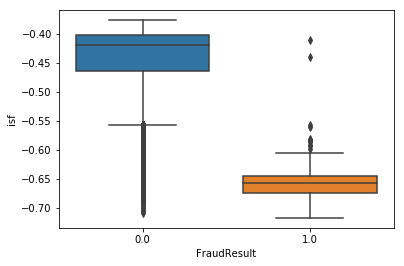

In [86]:
sns.boxplot(y=train['isf'],x=train['FraudResult'])

In [89]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
>>> lda = LinearDiscriminantAnalysis()

In [90]:
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [91]:
f1_score(y_train,lda.predict(X_train))

0.504424778761062

In [92]:
f1_score(y_test,lda.predict(X_test))

0.5283018867924528

In [114]:
train['lda1']=pd.DataFrame(lda.predict_proba(X))[0]
train['lda2']=pd.DataFrame(lda.predict_proba(X))[1]

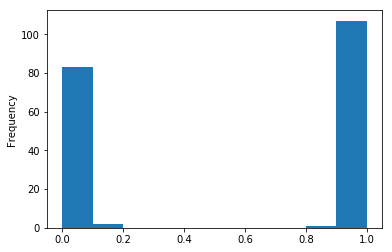

In [124]:
train[train.FraudResult==1].lda1.plot.hist()

In [125]:
from sklearn.neighbors import LocalOutlierFactor

In [137]:
lof=LocalOutlierFactor(n_neighbors=5, leaf_size=30, metric='minkowski', p=2, 
                       contamination=0.002, novelty=True)

In [138]:
lof.fit(X_train)

LocalOutlierFactor(algorithm='auto', contamination=0.002, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=5, novelty=True, p=2)

In [147]:
y_pred=lof.predict(X_train)

In [148]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
f1_score(y_train,y_pred)

0.0

In [142]:
(y_test==y_pred).mean()

0.9952960033450643

In [149]:
from sklearn.svm import OneClassSVM

In [151]:
svm=OneClassSVM(gamma='auto')

In [152]:
svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [157]:
y_pred=svm.predict(X_test)

In [161]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
#f1_score(y_test,y_pred)

In [162]:
y_pred.mean()

0.49851911216418693

In [168]:
y_pred=svm.score_samples(X_test)

In [171]:
np.corrcoef(y_pred,y_test)

array([[ 1.        , -0.19851772],
       [-0.19851772,  1.        ]])

In [172]:
from sklearn.neural_network import MLPClassifier

In [220]:
nn=MLPClassifier(hidden_layer_sizes=(100,10),activation='tanh',max_iter=1000,random_state=100,early_stopping=True,
             validation_fraction=0.2,n_iter_no_change=50)

In [221]:
from sklearn.model_selection import cross_val_score

In [222]:
cv=cross_val_score(nn,X,b,scoring='f1',verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.6min finished


In [223]:
cv

array([0.76315789, 0.56842105, 0.022567  ])

In [206]:
nn.fit(X_train,y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
       random_state=100, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.2, verbose=False, warm_start=False)

In [207]:
f1_score(y_train,nn.predict(X_train))

0.9180327868852458

In [208]:
f1_score(y_test,nn.predict(X_test))

0.7741935483870968

In [209]:
nn.fit(X,b)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
       random_state=100, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.2, verbose=False, warm_start=False)

In [210]:
xx=test.drop(['FraudResult','CurrencyCode', 'CountryCode','TransactionId','BatchId','month',
              'AccountId','SubscriptionId','CustomerId','TransactionStartTime'],axis=1)

In [211]:
xx=sc.transform(ce.transform(xx))

In [212]:
nn.predict(xx).sum()

102.0

In [213]:
pd.DataFrame(nn.predict(xx)).to_csv('NN Benchmark',index=True)

# Benchmark

In [18]:
X_train.columns

Index(['Amount', 'ChannelId', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'Value', 'TimeBetweenTransaction',
       'AmountBetweenTransaction', 'PreviousTransactionBetweenHour',
       'NumberOfTransactionWithinHour', 'AveAmtWithinPeriod', 'quarter',
       'week_of_month', 'weekday', 'hour'],
      dtype='object')

In [35]:
clf_best_cb=CatBoostClassifier(iterations=2000,learning_rate=0.4,depth=6,verbose=100,
                               cat_features=[1,2,3,4,5,9,12,13,14,15],
                     use_best_model=True,random_seed=1020,eval_metric='F1', early_stopping_rounds=100)

clf_best_cb.fit(X_train,y_train,eval_set=(X_test,y_test))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.26s	remaining: 42m 2s
100:	learn: 1.0000000	test: 0.9174312	best: 0.9174312 (38)	total: 1m 24s	remaining: 26m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9174311927
bestIteration = 38

Shrink model to first 39 iterations.


In [36]:
clf_best_cb=CatBoostClassifier(iterations=69,learning_rate=0.4,depth=6,verbose=100,
                               cat_features=[1,2,3,4,5,9,12,13,14,15],
                     random_seed=1020,eval_metric='F1')

clf_best_cb.fit(a,b)

0:	learn: 0.0000000	total: 1.5s	remaining: 1m 42s
68:	learn: 0.9921671	total: 1m 9s	remaining: 0us


Text(0.5,0,'Importance')

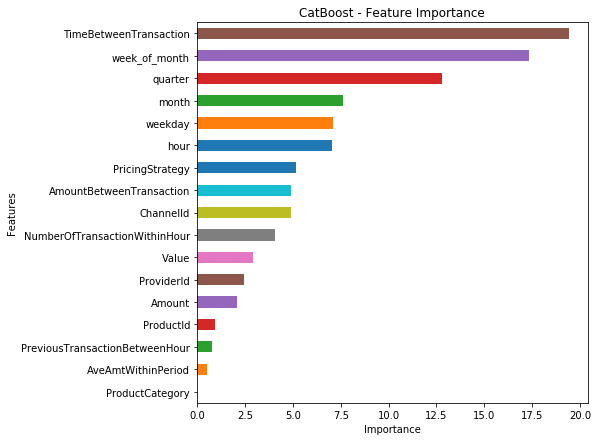

In [37]:
fea_imp = pd.DataFrame({'imp':clf_best_cb.feature_importances_, 'col': a.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(7, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [39]:
pd.DataFrame(clf_best_cb.predict(test[a.columns])).to_csv('Benchmark month stratified.csv',index=True)

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
cb=CatBoostClassifier(iterations=25,learning_rate=0.1,depth=5,verbose=100,cat_features=[1,2,3,4,5,9],
                      random_seed=1020,eval_metric='F1')

In [11]:
cv=cross_val_score(cb, a, b, scoring='f1', cv=5, verbose=1) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.0000000	total: 548ms	remaining: 13.2s
24:	learn: 0.8960573	total: 14.3s	remaining: 0us
0:	learn: 0.0000000	total: 434ms	remaining: 10.4s
24:	learn: 0.8677966	total: 13.4s	remaining: 0us
0:	learn: 0.0000000	total: 556ms	remaining: 13.3s
24:	learn: 0.9347079	total: 14.6s	remaining: 0us
0:	learn: 0.0000000	total: 569ms	remaining: 13.6s
24:	learn: 0.9355932	total: 13s	remaining: 0us
0:	learn: 0.0000000	total: 617ms	remaining: 14.8s
24:	learn: 0.8982456	total: 13.6s	remaining: 0us


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [12]:
cv

array([0.92105263, 0.92857143, 0.6984127 , 0.59375   , 0.91358025])

In [13]:
 cv.mean()

0.8110734010953309

In [14]:
cv.std()

0.13880256887445222

In [15]:
cb.fit(a,b)

0:	learn: 0.4985673	total: 811ms	remaining: 19.5s
24:	learn: 0.8977273	total: 15.3s	remaining: 0us


pd.DataFrame(cb.predict(test[a.columns])).to_csv('Benchmark no ids + profile2.csv',index=True)

# EDA

In [18]:
data.sample(5).T

,114383,120660,27227,112824,115983
AccountId,AccountId_4383,AccountId_312,AccountId_126,AccountId_3507,AccountId_4841
Amount,1000,5000,1000,700,-75
BatchId,BatchId_38734,BatchId_396,BatchId_109473,BatchId_114914,BatchId_73842
ChannelId,ChannelId_3,ChannelId_3,ChannelId_3,ChannelId_3,ChannelId_3
CountryCode,256,256,256,256,256
CurrencyCode,UGX,UGX,UGX,UGX,UGX
CustomerId,CustomerId_4840,CustomerId_641,CustomerId_448,CustomerId_3944,CustomerId_4840
FraudResult,NaN,NaN,0,NaN,NaN
PricingStrategy,2,2,2,2,2
ProductCategory,airtime,financial_services,airtime,airtime,financial_services


In [19]:
data.dtypes

AccountId                                 object
Amount                                   float64
BatchId                                   object
ChannelId                                 object
CountryCode                                int64
CurrencyCode                              object
CustomerId                                object
FraudResult                              float64
PricingStrategy                            int64
ProductCategory                           object
ProductId                                 object
ProviderId                                object
SubscriptionId                            object
TransactionId                             object
TransactionStartTime              datetime64[ns]
Value                                      int64
TimeBetweenTransaction                   float64
AmountBetweenTransaction                 float64
PreviousTransactionBetweenHour           float64
NumberOfTransactionWithinHour            float64
AveAmtWithinPeriod  

In [20]:
data.nunique()

AccountId                           4841
Amount                              2099
BatchId                           139493
ChannelId                              5
CountryCode                            1
CurrencyCode                           1
CustomerId                          7479
FraudResult                            2
PricingStrategy                        4
ProductCategory                       10
ProductId                             27
ProviderId                             6
SubscriptionId                      4836
TransactionId                     140681
TransactionStartTime              138574
Value                               1880
TimeBetweenTransaction             38600
AmountBetweenTransaction            4647
PreviousTransactionBetweenHour         2
NumberOfTransactionWithinHour       2001
AveAmtWithinPeriod                 16150
quarter                                2
week_of_month                          5
weekday                                7
hour            

In [21]:
data.drop(['CountryCode','CurrencyCode'],inplace=True,axis=1)

In [22]:
data.isnull().sum()

AccountId                             0
Amount                                0
BatchId                               0
ChannelId                             0
CustomerId                            0
FraudResult                       45019
PricingStrategy                       0
ProductCategory                       0
ProductId                             0
ProviderId                            0
SubscriptionId                        0
TransactionId                         0
TransactionStartTime                  0
Value                                 0
TimeBetweenTransaction                0
AmountBetweenTransaction              0
PreviousTransactionBetweenHour        0
NumberOfTransactionWithinHour         0
AveAmtWithinPeriod                    0
quarter                               0
week_of_month                         0
weekday                               0
hour                                  0
dtype: int64

In [23]:
num_col = ['Amount','Value','TimeBetweenTransaction','AmountBetweenTransaction','NumberOfTransactionWithinHour',
          'AveAmtWithinPeriod']

In [24]:
cat_col = [col for col in data.columns if col not in (num_col + ['BatchId','TransactionId','TransactionStartTime'])]
cat_col

['AccountId',
 'ChannelId',
 'CustomerId',
 'FraudResult',
 'PricingStrategy',
 'ProductCategory',
 'ProductId',
 'ProviderId',
 'SubscriptionId',
 'PreviousTransactionBetweenHour',
 'quarter',
 'week_of_month',
 'weekday',
 'hour']

## Numerical

Amount


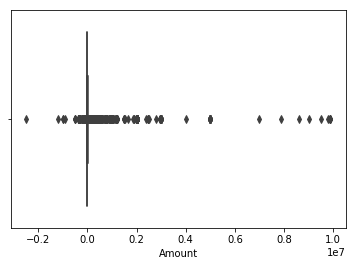

Value


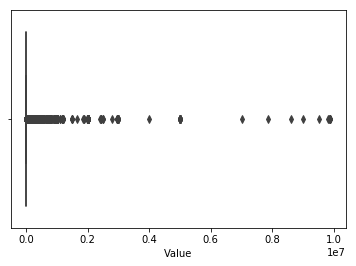

TimeBetweenTransaction


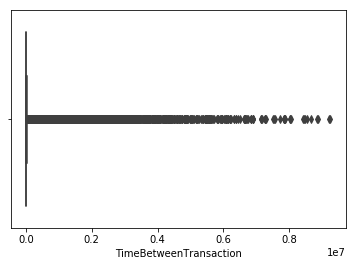

AmountBetweenTransaction


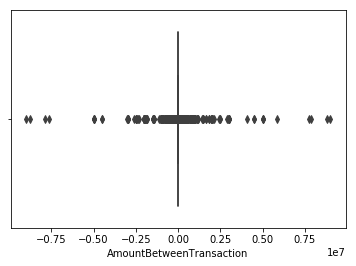

NumberOfTransactionWithinHour


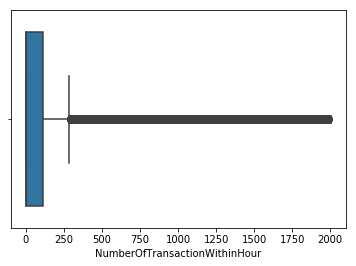

AveAmtWithinPeriod


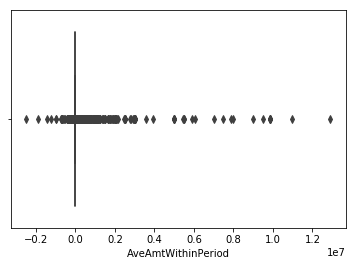

In [25]:
for col in num_col:
    print(col)
    sns.boxplot(data[col])
    plt.show()

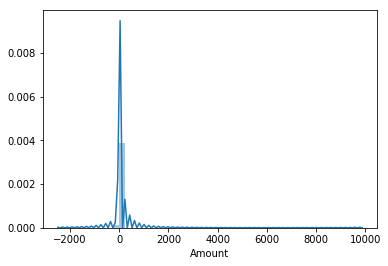

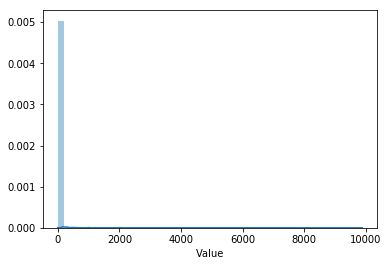

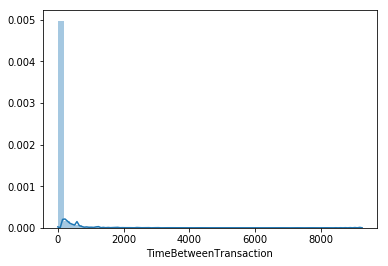

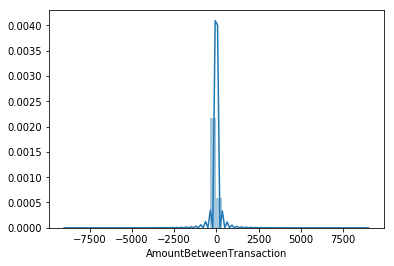

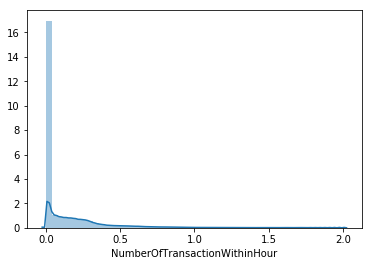

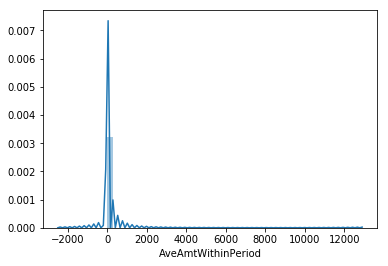

In [26]:
for col in num_col:
    sns.distplot(data[col].dropna()/1000)
    plt.show()

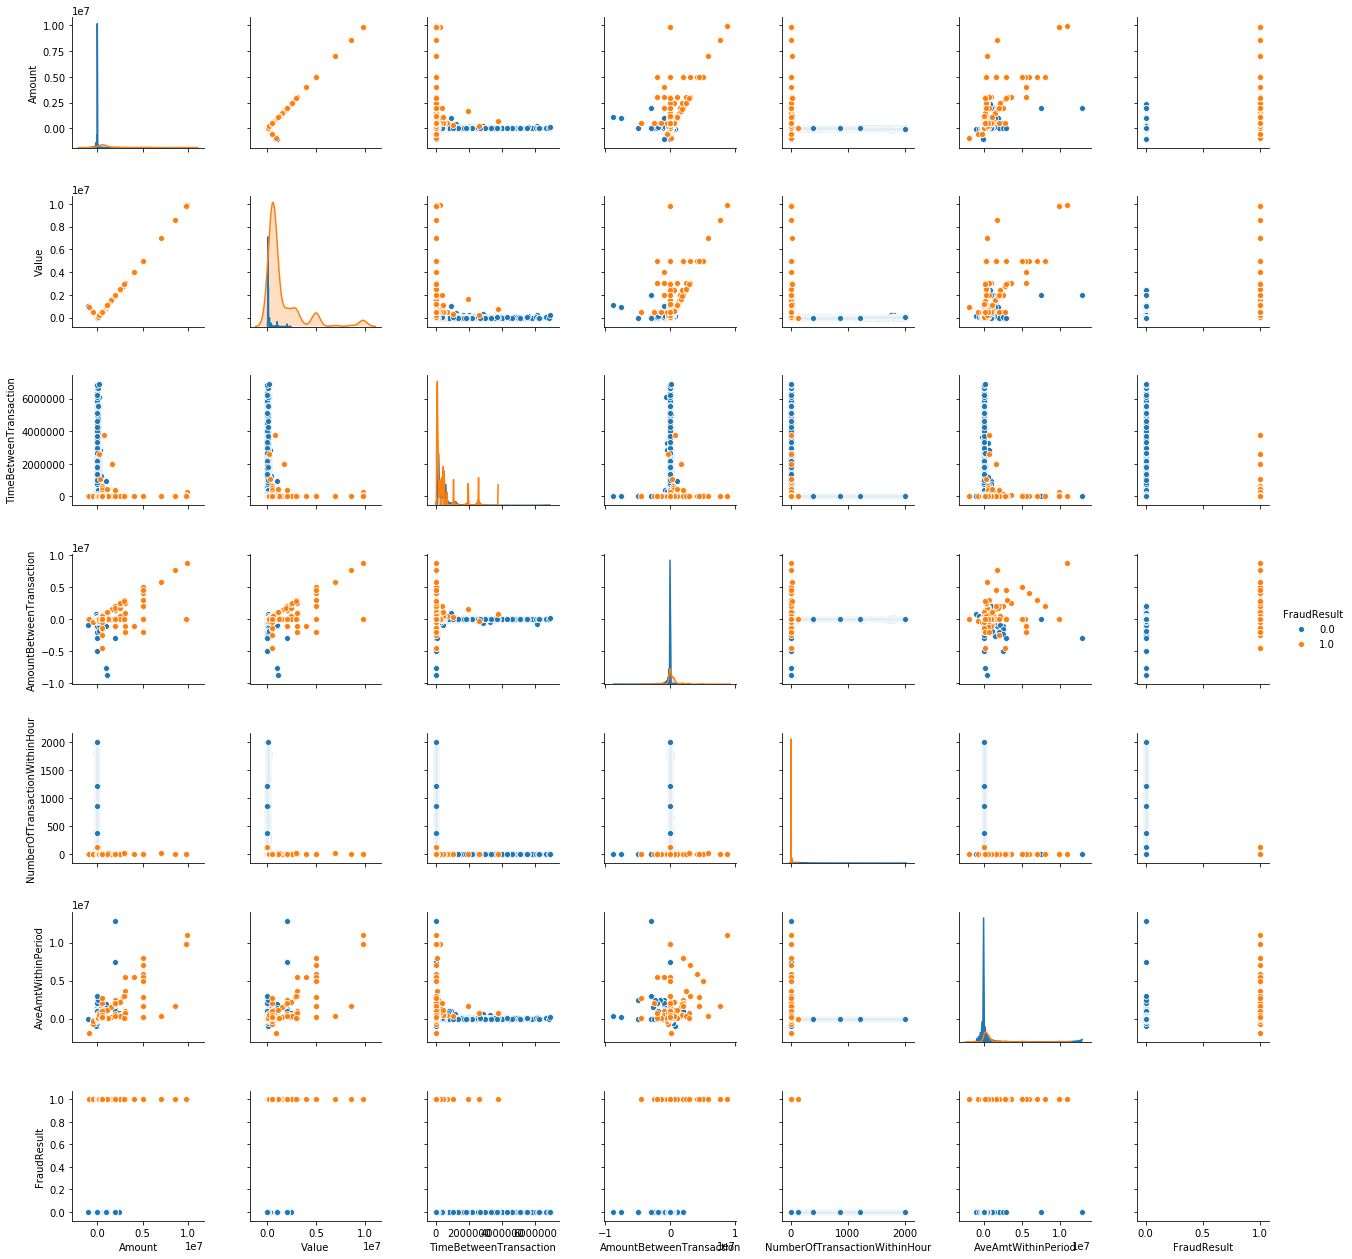

In [27]:
c=num_col + ['FraudResult']
sns.pairplot(data[c].dropna(),diag_kind='kde',hue='FraudResult')

In [40]:
data['is credit']=np.log(data['Amount']).isnull()

## Categorical

In [41]:
cat_col = cat_col + ['is credit']

NameError: name 'cat_col' is not defined

In [42]:
set(list(data.columns))-set(cat_col + num_col)

NameError: name 'cat_col' is not defined

In [31]:
data.nunique().sort_values()

is credit                              2
quarter                                2
FraudResult                            2
PreviousTransactionBetweenHour         2
PricingStrategy                        4
week_of_month                          5
ChannelId                              5
ProviderId                             6
weekday                                7
ProductCategory                       10
hour                                  24
ProductId                             27
Value                               1880
NumberOfTransactionWithinHour       2001
Amount                              2099
AmountBetweenTransaction            4647
SubscriptionId                      4836
AccountId                           4841
CustomerId                          7479
AveAmtWithinPeriod                 16150
TimeBetweenTransaction             38600
TransactionStartTime              138574
BatchId                           139493
TransactionId                     140681
dtype: int64

In [32]:
cat_co = [col for col in cat_col if data[col].nunique()<100]

ChannelId


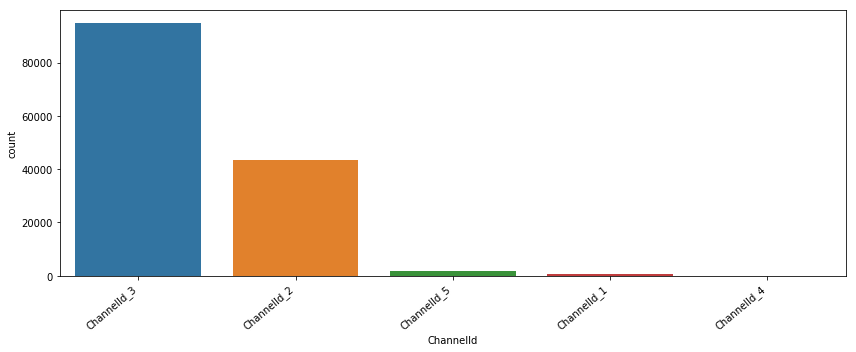

FraudResult


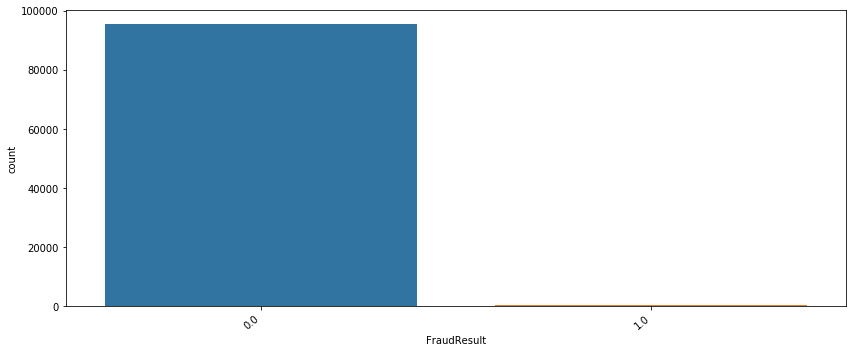

PricingStrategy


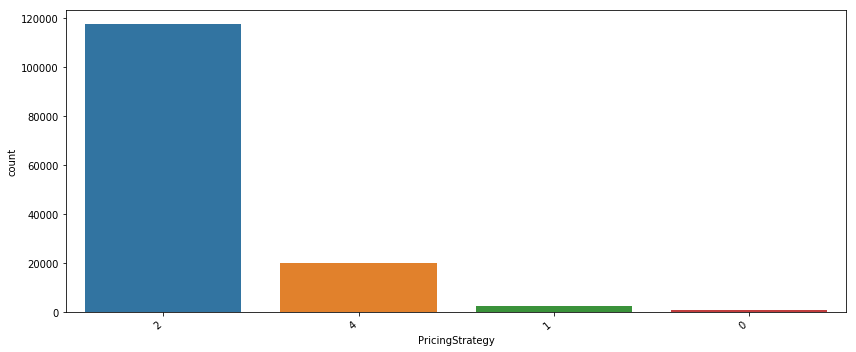

ProductCategory


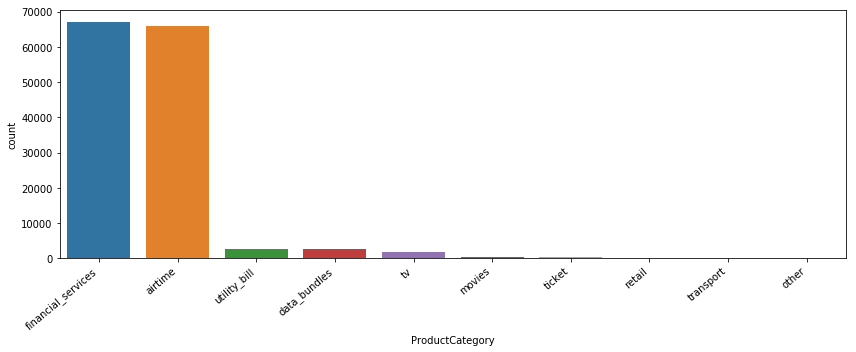

ProductId


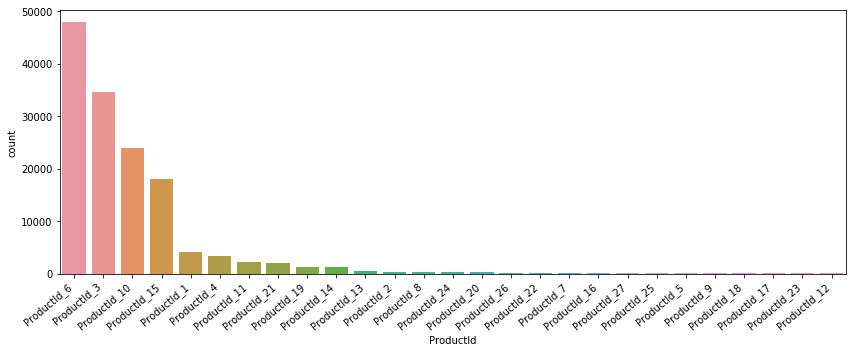

ProviderId


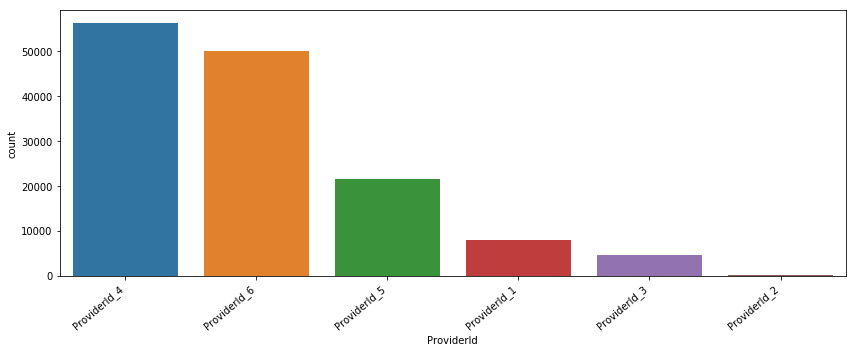

PreviousTransactionBetweenHour


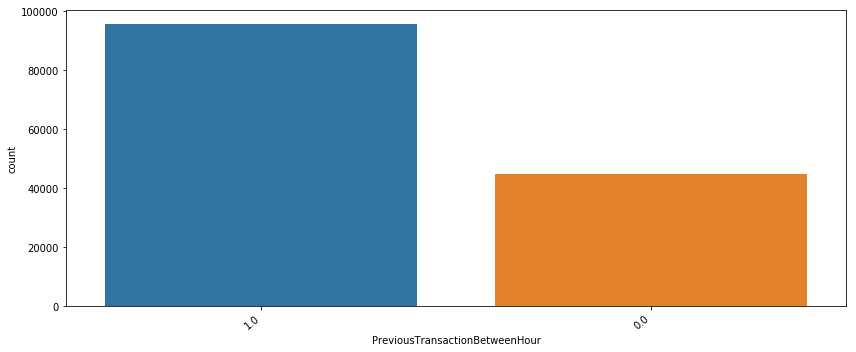

quarter


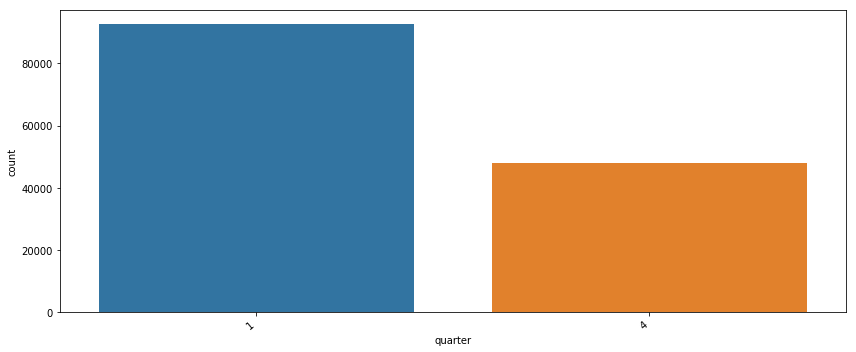

week_of_month


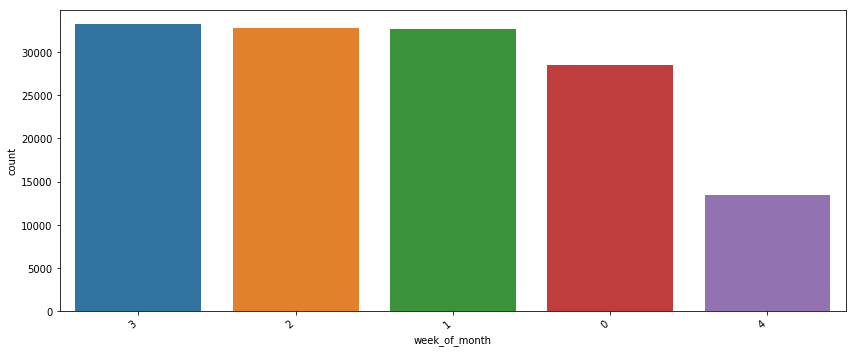

weekday


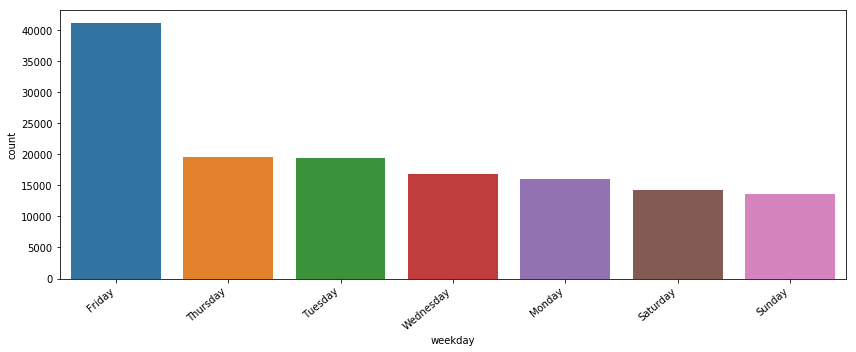

hour


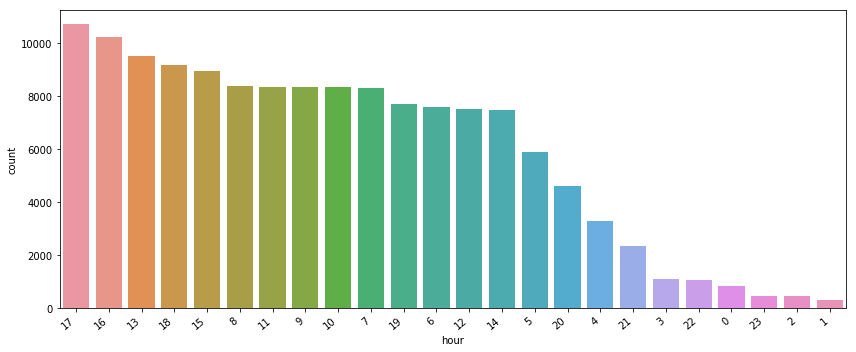

is credit


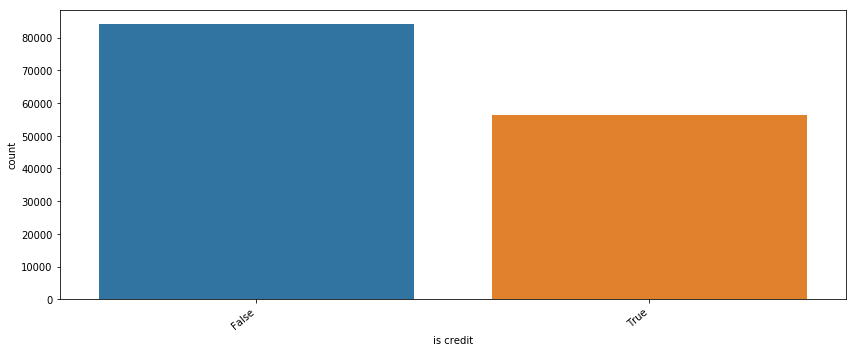

In [33]:
for col in cat_co:
        print(col)
        plt.figure(figsize=(12,5))
        ax=sns.countplot(data[col],order = data[col].value_counts().index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.tight_layout()
        plt.show()

In [34]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [35]:
cat_col

['AccountId',
 'ChannelId',
 'CustomerId',
 'FraudResult',
 'PricingStrategy',
 'ProductCategory',
 'ProductId',
 'ProviderId',
 'SubscriptionId',
 'PreviousTransactionBetweenHour',
 'quarter',
 'week_of_month',
 'weekday',
 'hour',
 'is credit']

In [36]:
r=[]
for x in cat_col:
    cc=cat_col
    print(x)
    for y in cc:
        if x!=y:
            o=cramers_v(data.dropna()[x],data.dropna()[y])
            r.append([x,y,o])
    #cc.remove(x)

AccountId
ChannelId
CustomerId
FraudResult
PricingStrategy
ProductCategory
ProductId
ProviderId
SubscriptionId
PreviousTransactionBetweenHour
quarter
week_of_month
weekday
hour
is credit


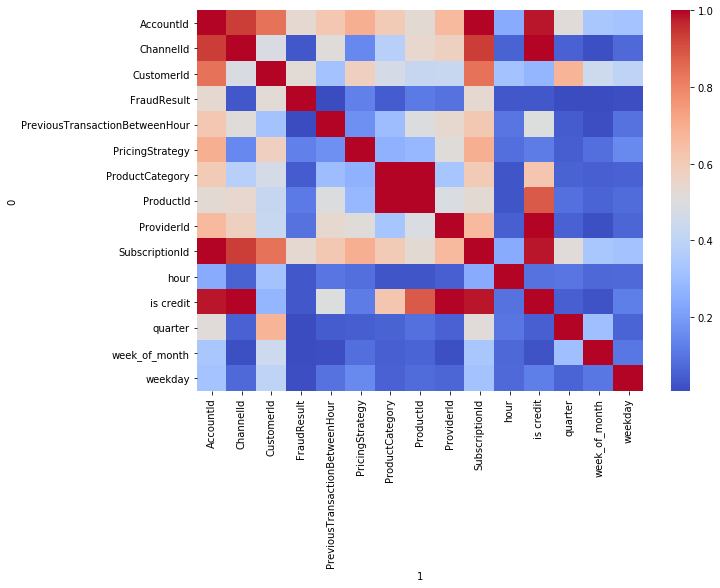

In [37]:
plt.figure(figsize=(10,7))
sns.heatmap(pd.pivot_table(data=pd.DataFrame(r).sort_values(by=2,ascending=False),
                                                            index=0,columns=1,values=2).fillna(1),cmap='coolwarm')

<Figure size 720x504 with 0 Axes>

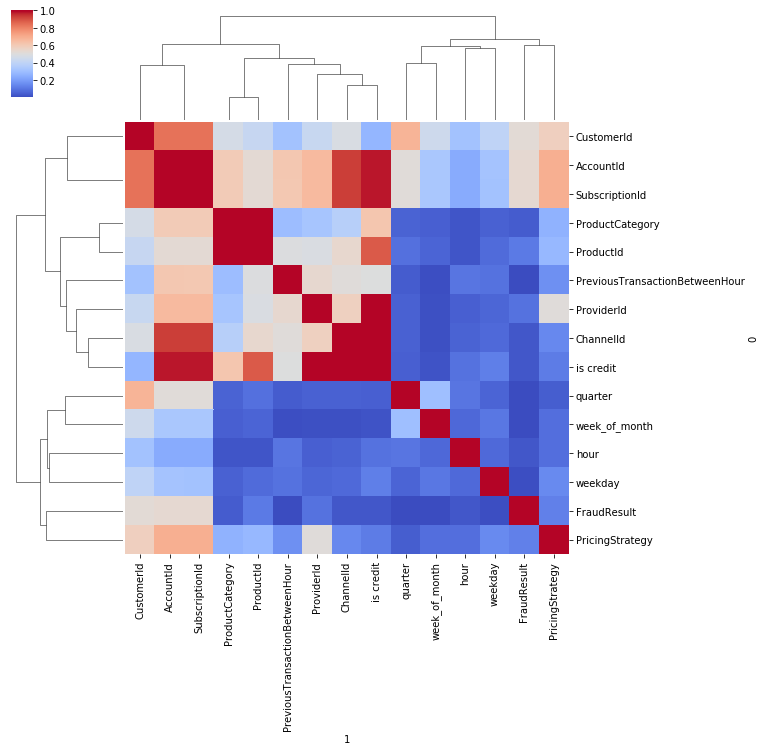

In [38]:
plt.figure(figsize=(10,7))
sns.clustermap(pd.pivot_table(data=pd.DataFrame(r).sort_values(by=2,ascending=False),
                                                            index=0,columns=1,values=2).fillna(1),cmap='coolwarm')

# Feature Creation

In [39]:
data.ProductCategory=data.ProductCategory.map({'financial_services':'financial_services',
                                               'airtime':'airtime'}).fillna('others')

In [40]:
data.ChannelId=data.ChannelId.map({'ChannelId_2':'ChannelId_2',
                                   'ChannelId_3':'ChannelId_3'}).fillna('others')

In [41]:
data.ProductId=data.ProductId.map({'ProductId_5':'ProductId_22',
                                     'ProductId_9':'ProductId_22',
                                    'ProductId_22':'ProductId_22',
                                    'ProductId_6':'ProductId_6',
                                    'ProductId_3':'ProductId_3',
                                    'ProductId_10':'ProductId_10',
                                    'ProductId_15':'ProductId_15',}).fillna('others')

In [42]:
data.ProviderId=data.ProviderId.map({'ProviderId_2':'others','ProviderId_3':'others'}).fillna(data.ProviderId)

In [43]:
data.columns

Index(['AccountId', 'Amount', 'BatchId', 'ChannelId', 'CustomerId',
       'FraudResult', 'PricingStrategy', 'ProductCategory', 'ProductId',
       'ProviderId', 'SubscriptionId', 'TransactionId', 'TransactionStartTime',
       'Value', 'TimeBetweenTransaction', 'AmountBetweenTransaction',
       'PreviousTransactionBetweenHour', 'NumberOfTransactionWithinHour',
       'AveAmtWithinPeriod', 'quarter', 'week_of_month', 'weekday', 'hour',
       'is credit'],
      dtype='object')

In [44]:
ccc=['Amount','Value',
             'TimeBetweenTransaction', 'AmountBetweenTransaction','PreviousTransactionBetweenHour', 
            'NumberOfTransactionWithinHour', 'AveAmtWithinPeriod','is late']

In [45]:
data['is late']=((data.hour <= 5) | (data.hour>=20))

In [46]:
channel_grp=data[data.FraudResult==0].groupby('ChannelId').agg(['mean','std','skew','count'])[ccc]
prodcat_grp=data[data.FraudResult==0].groupby('ProductCategory').agg(['mean','std','skew','count'])[ccc]
providerid_grp=data[data.FraudResult==0].groupby('ProviderId').agg(['mean','std','skew','count'])[ccc]
#pricing_grp=data[data.FraudResult==0].groupby('PricingStrategy').agg(['mean','std','skew'])

In [47]:
data_mod=data.merge(channel_grp,on='ChannelId').merge(prodcat_grp,on='ProductCategory').merge(providerid_grp,on='ProviderId')

In [48]:
test=data[data.FraudResult.isnull()]
train=data.dropna()

In [49]:
train.FraudResult.mean()

0.00201752001839811

# Modelling

In [50]:
#Remember yor removed ids
X=train.drop(['FraudResult','TransactionId','BatchId','CustomerId','AccountId',
              'SubscriptionId','TransactionStartTime'],axis=1)
y=train['FraudResult']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4112)

In [52]:
import category_encoders as ce

In [53]:
cat=[col for col in X_train.columns if X_train[col].nunique()<30]

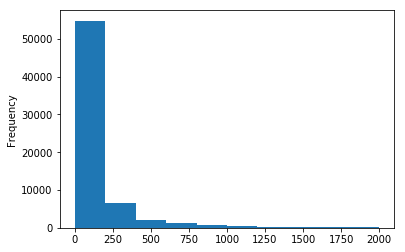

In [54]:
X_train.NumberOfTransactionWithinHour.plot.hist()

In [55]:
encoder_catboost = ce.cat_boost.CatBoostEncoder(cols=cat)
X_train_catboost=encoder_catboost.fit_transform(X_train,y_train)
X_test_catboost=encoder_catboost.transform(X_test)

In [56]:
X_catboost=encoder_catboost.fit_transform(X,y)

In [57]:
clf_best_cb=CatBoostClassifier(iterations=2000,learning_rate=0.1,depth=5,verbose=100,
                     use_best_model=True,random_seed=12,eval_metric='F1', early_stopping_rounds=100)

clf_best_cb.fit(X_train_catboost,y_train,eval_set=(X_test_catboost,y_test))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 122ms	remaining: 4m 3s
100:	learn: 0.9815498	test: 0.8571429	best: 0.8800000 (46)	total: 11.3s	remaining: 3m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.88
bestIteration = 46

Shrink model to first 47 iterations.


In [58]:
clf_best_cb=CatBoostClassifier(iterations=62,learning_rate=0.1,depth=5,verbose=100,
                     random_seed=12,eval_metric='F1')

clf_best_cb.fit(X_catboost,y)

0:	learn: 0.7842227	total: 145ms	remaining: 8.82s
61:	learn: 0.9653333	total: 10.7s	remaining: 0us


Text(0.5,0,'Importance')

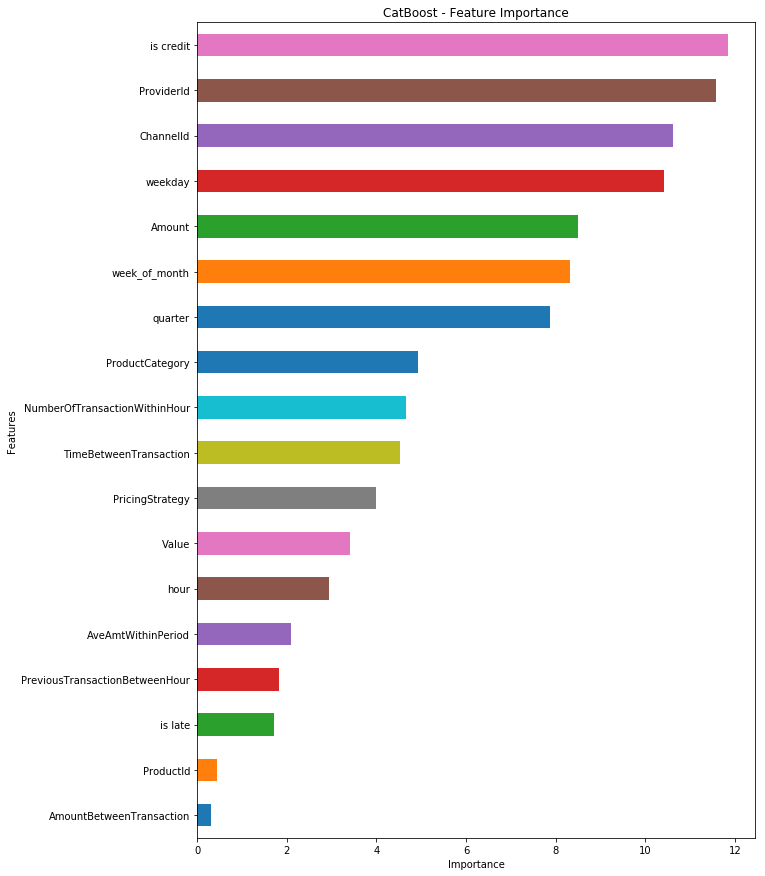

In [59]:
fea_imp = pd.DataFrame({'imp': clf_best_cb.feature_importances_, 'col': X_train_catboost.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [60]:
from xgboost import XGBClassifier

In [61]:
xg=XGBClassifier(max_depth=7,learning_rate=0.1, n_estimators=1000, verbosity=1, random_state=0)

In [62]:
xg.fit(X_train_catboost, y_train,eval_set=[(X_test_catboost, y_test)], eval_metric='aucpr',
       early_stopping_rounds=100, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [63]:
from sklearn.metrics import f1_score
f1_score(y_test,xg.predict(X_test_catboost))

0.8686868686868686

Text(0.5,0,'Importance')

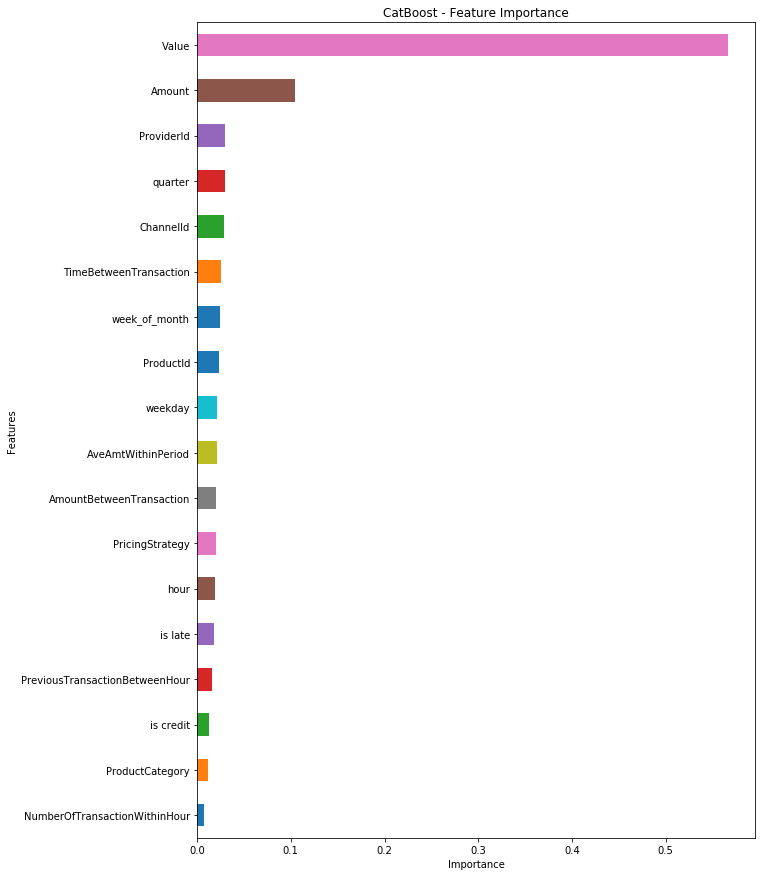

In [64]:
fea_imp = pd.DataFrame({'imp': xg.feature_importances_, 'col': X_train_catboost.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-50:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [65]:
xx=encoder_catboost.transform(test.drop(['FraudResult','TransactionId','BatchId','CustomerId','AccountId',
              'SubscriptionId','TransactionStartTime'],axis=1))

In [66]:
xg.predict(xx).mean()

0.0012883449210333415

In [67]:
clf_best_cb.predict(xx).mean()

0.001421621981829894

pd.DataFrame(xg.predict(xx)).to_csv('XGboost Xente 3 with ids.csv')

pd.DataFrame(clf_best_cb.predict(xx)).to_csv('Catboost Xente 3 with ids.csv')

# Futher Feature Engineering

In [68]:
import featuretools as ft

In [69]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'Xente')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'Data', dataframe = data, index = 'TransactionId',
                         time_index = 'TransactionStartTime')

Entityset: Xente
  Entities:
    Data [Rows: 140681, Columns: 25]
  Relationships:
    No relationships

# KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
sc=MinMaxScaler()

In [73]:
X_train_catboost_scaled = sc.fit_transform(X_train_catboost)
X_test_catboost_scaled = sc.transform(X_test_catboost)

In [74]:
knn=KNeighborsClassifier(n_neighbors=5,weights='uniform',leaf_size=30)

In [75]:
knn.fit(X_train_catboost,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
print(f1_score(y_train,knn.predict(X_train_catboost)))
print(f1_score(y_test,knn.predict(X_test_catboost)))

0.8159999999999998
0.7021276595744681


In [77]:
knn1=KNeighborsClassifier(n_neighbors=5,weights='uniform',leaf_size=30)
knn2=KNeighborsClassifier(n_neighbors=7,weights='uniform',leaf_size=30)
knn3=KNeighborsClassifier(n_neighbors=9,weights='uniform',leaf_size=30)
knn4=KNeighborsClassifier(n_neighbors=11,weights='uniform',leaf_size=30)
knn5=KNeighborsClassifier(n_neighbors=5,weights='distance',leaf_size=30)
knn6=KNeighborsClassifier(n_neighbors=7,weights='distance',leaf_size=30)
knn7=KNeighborsClassifier(n_neighbors=9,weights='distance',leaf_size=30)
knn8=KNeighborsClassifier(n_neighbors=11,weights='distance',leaf_size=30)

In [78]:
knn1.fit(X_train_catboost,y_train)
knn2.fit(X_train_catboost,y_train)
knn3.fit(X_train_catboost,y_train)
knn4.fit(X_train_catboost,y_train)
knn5.fit(X_train_catboost,y_train)
knn6.fit(X_train_catboost,y_train)
knn7.fit(X_train_catboost,y_train)
knn8.fit(X_train_catboost,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

In [79]:
X_train_catboost['knn1']=knn1.predict(X_train_catboost)
X_train_catboost['knn2']=knn2.predict(X_train_catboost.drop('knn1',axis=1))
X_train_catboost['knn3']=knn3.predict(X_train_catboost.drop(['knn1','knn2'],axis=1))
X_train_catboost['knn4']=knn4.predict(X_train_catboost.drop(['knn1','knn2','knn3'],axis=1))
X_train_catboost['knn5']=knn5.predict(X_train_catboost.drop(['knn1','knn2','knn3','knn4'],axis=1))
X_train_catboost['knn6']=knn6.predict(X_train_catboost.drop(['knn1','knn2','knn3','knn4','knn5'],axis=1))
X_train_catboost['knn7']=knn7.predict(X_train_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6'],axis=1))
X_train_catboost['knn8']=knn8.predict(X_train_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6','knn7'],axis=1))

In [80]:
X_test_catboost['knn1']=knn1.predict(X_test_catboost)
X_test_catboost['knn2']=knn2.predict(X_test_catboost.drop('knn1',axis=1))
X_test_catboost['knn3']=knn3.predict(X_test_catboost.drop(['knn1','knn2'],axis=1))
X_test_catboost['knn4']=knn4.predict(X_test_catboost.drop(['knn1','knn2','knn3'],axis=1))
X_test_catboost['knn5']=knn5.predict(X_test_catboost.drop(['knn1','knn2','knn3','knn4'],axis=1))
X_test_catboost['knn6']=knn6.predict(X_test_catboost.drop(['knn1','knn2','knn3','knn4','knn5'],axis=1))
X_test_catboost['knn7']=knn7.predict(X_test_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6'],axis=1))
X_test_catboost['knn8']=knn8.predict(X_test_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6','knn7'],axis=1))

In [81]:
X_test_catboost.corrwith(y_test)

Amount                            0.592630
ChannelId                         0.029361
PricingStrategy                   0.084728
ProductCategory                   0.033806
ProductId                         0.099517
ProviderId                        0.083737
Value                             0.611382
TimeBetweenTransaction            0.003682
AmountBetweenTransaction          0.304991
PreviousTransactionBetweenHour    0.010437
NumberOfTransactionWithinHour    -0.018349
AveAmtWithinPeriod                0.457640
quarter                           0.015828
week_of_month                    -0.005733
weekday                           0.009577
hour                              0.039404
is credit                         0.030911
is late                           0.017064
knn1                              0.712078
knn2                              0.710988
knn3                              0.743289
knn4                              0.757717
knn5                              0.760431
knn6       

In [82]:
clf_best_cb=CatBoostClassifier(iterations=2000,learning_rate=0.01,depth=5,verbose=100,
                     use_best_model=True,random_seed=12,eval_metric='F1', early_stopping_rounds=100)

clf_best_cb.fit(X_train_catboost,y_train,eval_set=(X_test_catboost,y_test))

0:	learn: 1.0000000	test: 0.7551020	best: 0.7551020 (0)	total: 341ms	remaining: 11m 22s
100:	learn: 1.0000000	test: 0.7600000	best: 0.7600000 (1)	total: 13.2s	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.76
bestIteration = 1

Shrink model to first 2 iterations.


Text(0.5,0,'Importance')

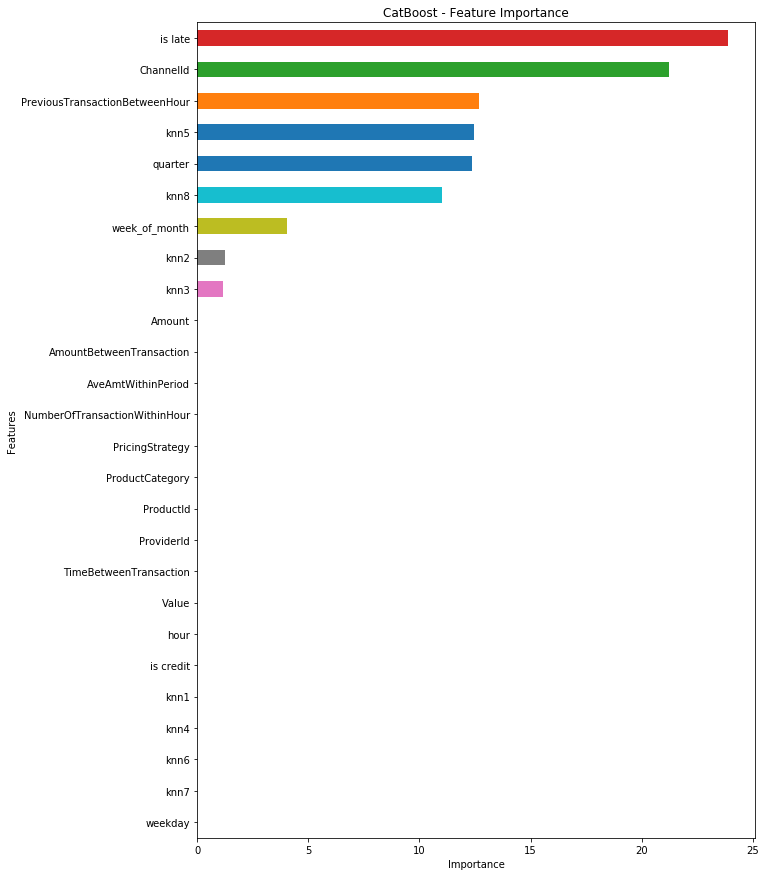

In [83]:
fea_imp = pd.DataFrame({'imp': clf_best_cb.feature_importances_, 'col': X_train_catboost.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

knn1.fit(X_catboost,y)
knn2.fit(X_catboost,y)
knn3.fit(X_catboost,y)
knn4.fit(X_catboost,y)
knn5.fit(X_catboost,y)
knn6.fit(X_catboost,y)
knn7.fit(X_catboost,y)
knn8.fit(X_catboost,y)

In [84]:
X_catboost['knn1']=knn1.predict(X_catboost)
X_catboost['knn2']=knn2.predict(X_catboost.drop('knn1',axis=1))
X_catboost['knn3']=knn3.predict(X_catboost.drop(['knn1','knn2'],axis=1))
X_catboost['knn4']=knn4.predict(X_catboost.drop(['knn1','knn2','knn3'],axis=1))
X_catboost['knn5']=knn5.predict(X_catboost.drop(['knn1','knn2','knn3','knn4'],axis=1))
X_catboost['knn6']=knn6.predict(X_catboost.drop(['knn1','knn2','knn3','knn4','knn5'],axis=1))
X_catboost['knn7']=knn7.predict(X_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6'],axis=1))
X_catboost['knn8']=knn8.predict(X_catboost.drop(['knn1','knn2','knn3','knn4','knn5','knn6','knn7'],axis=1))

In [85]:
clf_best_cb=CatBoostClassifier(iterations=7,learning_rate=0.01,depth=5,verbose=100,
                     random_seed=12,eval_metric='F1')

clf_best_cb.fit(X_catboost,y)

0:	learn: 0.9304813	total: 241ms	remaining: 1.45s
6:	learn: 0.9304813	total: 1.54s	remaining: 0us


Text(0.5,0,'Importance')

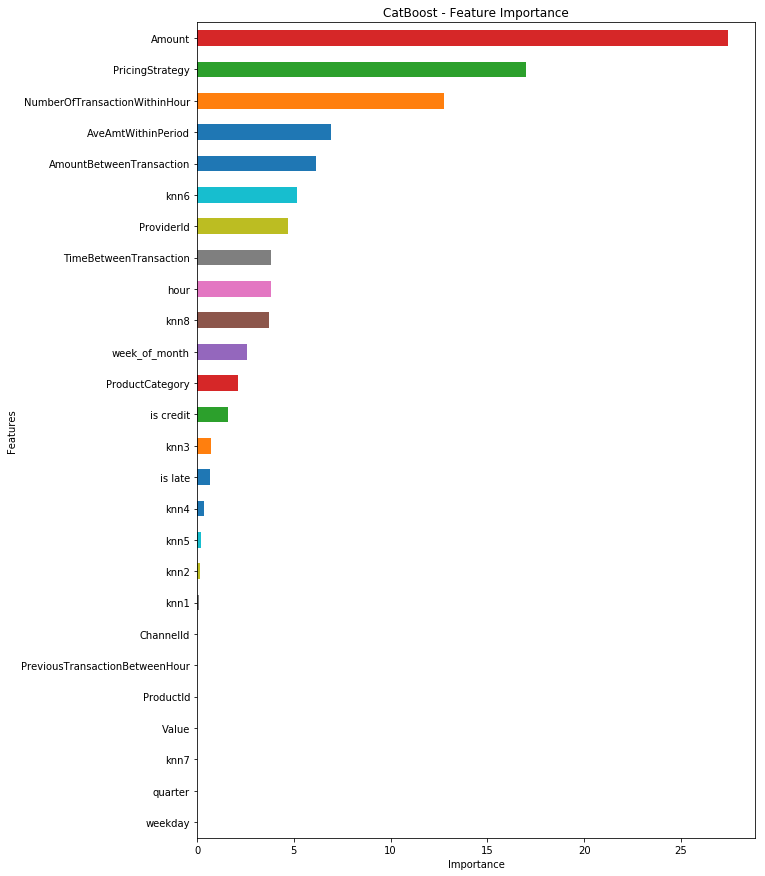

In [86]:
fea_imp = pd.DataFrame({'imp': clf_best_cb.feature_importances_, 'col': X_train_catboost.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [87]:
X_train_catboost.columns

Index(['Amount', 'ChannelId', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'Value', 'TimeBetweenTransaction',
       'AmountBetweenTransaction', 'PreviousTransactionBetweenHour',
       'NumberOfTransactionWithinHour', 'AveAmtWithinPeriod', 'quarter',
       'week_of_month', 'weekday', 'hour', 'is credit', 'is late', 'knn1',
       'knn2', 'knn3', 'knn4', 'knn5', 'knn6', 'knn7', 'knn8'],
      dtype='object')

In [88]:
xx['knn1']=knn1.predict(xx)
xx['knn2']=knn2.predict(xx.drop('knn1',axis=1))
xx['knn3']=knn3.predict(xx.drop(['knn1','knn2'],axis=1))
xx['knn4']=knn4.predict(xx.drop(['knn1','knn2','knn3'],axis=1))
xx['knn5']=knn5.predict(xx.drop(['knn1','knn2','knn3','knn4'],axis=1))
xx['knn6']=knn6.predict(xx.drop(['knn1','knn2','knn3','knn4','knn5'],axis=1))
xx['knn7']=knn7.predict(xx.drop(['knn1','knn2','knn3','knn4','knn5','knn6'],axis=1))
xx['knn8']=knn8.predict(xx.drop(['knn1','knn2','knn3','knn4','knn5','knn6','knn7'],axis=1))

In [89]:
clf_best_cb.predict(xx).mean()

0.0015771118860925387

pd.DataFrame(clf_best_cb.predict(xx)).to_csv('Catboost Xente 3 no ids & knn.csv')

## PCA

In [90]:
from sklearn.decomposition import PCA

In [91]:
pca=PCA(n_components=15,random_state=11)

In [92]:
X_tr_cb_sc=sc.fit_transform(X_train_catboost)
X_te_cb_sc=sc.transform(X_test_catboost)

In [93]:
pca.fit(X_tr_cb_sc,y_train)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=11,
  svd_solver='auto', tol=0.0, whiten=False)

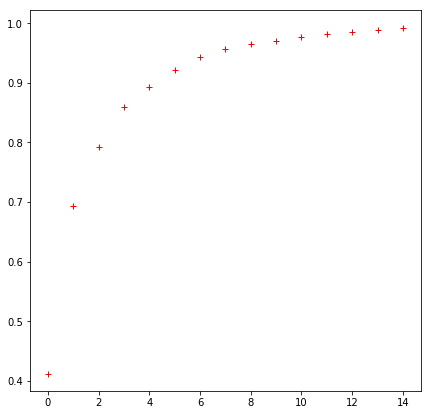

In [94]:
plt.figure(figsize=(7,7))
plt.plot(pca.explained_variance_ratio_.cumsum(),'r+')

In [95]:
X_tr_pca=pca.transform(X_tr_cb_sc)
X_te_pca=pca.transform(X_te_cb_sc)

In [97]:
pca.explained_variance_ratio_.sum()

0.9925784827906438

In [108]:
clf_best_cb=CatBoostClassifier(iterations=2000,learning_rate=0.01,depth=5,verbose=100,
                     use_best_model=True,random_seed=12,eval_metric='F1', early_stopping_rounds=100)

clf_best_cb.fit(X_tr_pca,y_train,eval_set=(X_te_pca,y_test))

0:	learn: 0.9309091	test: 0.7647059	best: 0.7647059 (0)	total: 109ms	remaining: 3m 38s
100:	learn: 0.9963899	test: 0.7600000	best: 0.7800000 (38)	total: 10.8s	remaining: 3m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.78
bestIteration = 38

Shrink model to first 39 iterations.


In [109]:
X_pca=pca.fit_transform(X_catboost,y)

In [110]:
clf_best_cb=CatBoostClassifier(iterations=39,learning_rate=0.01,depth=5,verbose=100,
                     random_seed=12,eval_metric='F1')

clf_best_cb.fit(X_pca,y)

0:	learn: 0.1929825	total: 354ms	remaining: 13.4s
38:	learn: 0.7818182	total: 6.83s	remaining: 0us


In [112]:
xx_pca=pca.transform(xx)

In [113]:
pd.DataFrame(clf_best_cb.predict(xx_pca)).to_csv('Catboost pca.csv')

# KMEANS

In [115]:
from sklearn.cluster import KMeans

In [158]:
km=KMeans(n_clusters=2,random_state=3,max_iter=10000)

In [159]:
km.fit(X_tr_cb_sc,y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=0)

In [160]:
pred=pd.DataFrame(km.predict(X_te_cb_sc))

In [161]:
pred.mean()

0    0.068574
dtype: float64

In [162]:
#pred[0]=pred[0].map({0:1,1:0})

In [163]:
pred.corrwith(y_test)

0   -0.009427
dtype: float64

In [164]:
f1_score(y_test.values,pred[0].values)

0.0

(y_test.values==pred[0].values).mean()